## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_wavelet_indoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = True
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 3208,
 3: 12832,
 4: 51328,
 5: 205312,
 6: 821248,
 7: 3284992,
 8: 13139968,
 9: 52559872}

Running 12760 CDFs


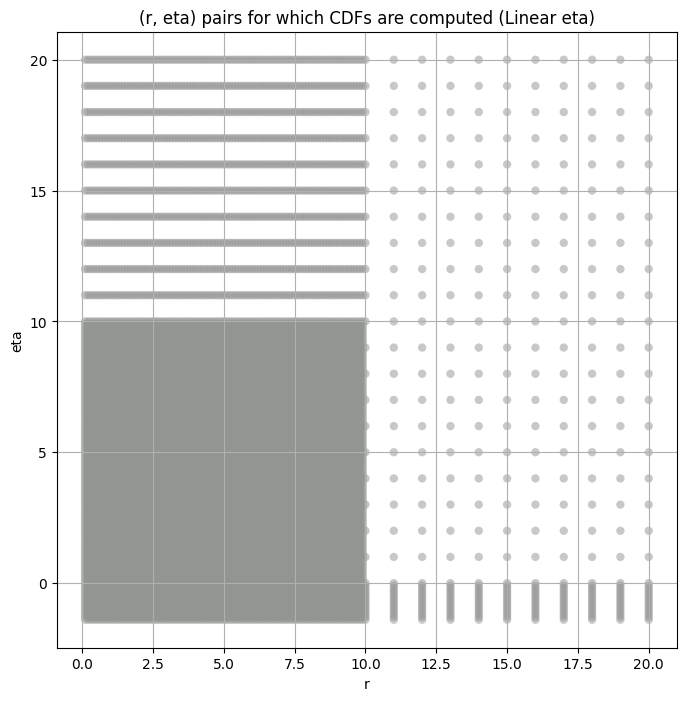

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [01:08<00:00, 1469.56it/s]


Layer 3


100%|██████████| 100000/100000 [01:17<00:00, 1282.76it/s]


Layer 4


100%|██████████| 100000/100000 [01:18<00:00, 1273.92it/s]


Layer 5


100%|██████████| 100000/100000 [01:09<00:00, 1439.59it/s]


Layer 6


100%|██████████| 100000/100000 [01:08<00:00, 1469.27it/s]


Layer 7


100%|██████████| 100000/100000 [01:21<00:00, 1229.97it/s]


Layer 8


100%|██████████| 100000/100000 [01:13<00:00, 1362.04it/s]


Layer 9


100%|██████████| 100000/100000 [01:19<00:00, 1252.39it/s]


obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.167439e+07  2.007571e+07  2.336055e+07   0.787101    0.382352   
3      4.835927e+06  4.598368e+06  5.083178e+06   1.799972    1.476695   
4      1.034581e+06  9.740716e+05  1.099110e+06   3.519323    2.922325   
5      1.983194e+05  1.846769e+05  2.125875e+05   5.446397    4.604024   
6      3.580229e+04  3.279927e+04  3.896280e+04   9.192647    7.647657   
7      6.274311e+03  5.654861e+03  6.950309e+03  14.085468   11.431098   
8      1.189420e+03  1.047309e+03  1.345900e+03  21.680420   17.037355   
9      2.567601e+02  2.218154e+02  2.951868e+02  28.972792   22.108063   

       kurt_upper  total_samples  
layer                             
2        1.240317         3208.0  
3        2.147720        12832.0  
4        4.190051        51328.0  
5        6.386241       205312.0  
6       10.959983       821248.0  
7       17.666815      3284992.0  
8       27.775066     13139968.0  
9       38.456100     52559872.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      2.167439e+07   2.167439e+07    1.871530e+07    1.697784e+07   
3      4.835927e+06   4.835927e+06    4.529936e+06    4.323602e+06   
4      1.034581e+06   1.034581e+06    1.004630e+06    9.825007e+05   
5      1.983194e+05   1.983194e+05    1.942993e+05    1.912279e+05   
6      3.580229e+04   3.580229e+04    3.477591e+04    3.400757e+04   
7      6.274311e+03   6.274312e+03    6.031297e+03    5.856020e+03   
8      1.189420e+03   1.189420e+03    1.126550e+03    1.082473e+03   
9      2.567601e+02   2.567601e+02    2.400950e+02    2.286641e+02   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        1.563857e+07     1.450176e+07     1.260052e+07     1.098983e+07   
3        4.158966e+06     4.013843e+06     3.766787e+06     3.554410e+06   
4        9.639316e+05     9.473351e+05     9.181127e+05     8.921752e+05   
5        1.885393e+05     1.860904e+05     1.816928e+05     1.777477e+05   
6        3.334605e+04     3.274940e+04     3.170084e+04     3.078198e+04   
7        5.706504e+03     5.574027e+03     5.344634e+03     5.147415e+03   
8        1.045787e+03     1.013897e+03     9.595205e+02     9.136019e+02   
9        2.192569e+02     2.111496e+02     1.975381e+02     1.862859e+02   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         9.647791e+06     8.500411e+06     7.484262e+06     5.165562e+06  
3         3.367987e+06     3.201553e+06     3.048154e+06     2.651824e+06  
4         8.687516e+05     8.473121e+05     8.275373e+05     7.754724e+05  
5         1.741580e+05     1.708555e+05     1.677694e+05     1.594286e+05  
6         2.995254e+04     2.919538e+04     2.849506e+04     2.665484e+04  
7         4.971609e+03     4.812443e+03     4.666836e+03     4.292497e+03  
8         8.736547e+02     8.381975e+02     8.062808e+02     7.258997e+02  
9         1.766671e+02     1.682534e+02     1.607824e+02     1.424085e+02

####
Layer  2


100%|██████████| 12760/12760 [00:07<00:00, 1761.30it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.05118895449643368 21674388.0


100%|██████████| 12760/12760 [00:56<00:00, 225.09it/s] 


Finding Minimum after computing 12760 CDFs
2 25 0.05119474155805004 18715304.0


100%|██████████| 12760/12760 [00:06<00:00, 2000.88it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.05120816125003558 16977836.0


100%|██████████| 12760/12760 [00:02<00:00, 4303.74it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.05453117146518327 15638571.0


100%|██████████| 12760/12760 [01:09<00:00, 183.82it/s] 


Finding Minimum after computing 12760 CDFs
2 100 0.06226269895408054 14501763.0


100%|██████████| 12760/12760 [00:09<00:00, 1399.26it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.0780562536300663 12600519.0


100%|██████████| 12760/12760 [00:09<00:00, 1375.73it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.09352428865290208 10989831.0


100%|██████████| 12760/12760 [00:06<00:00, 1977.63it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.10827510753309855 9647791.0


100%|██████████| 12760/12760 [00:03<00:00, 3461.66it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.12312512694494548 8500411.0


100%|██████████| 12760/12760 [00:03<00:00, 3719.35it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.13774936092382883 7484262.5


100%|██████████| 12760/12760 [00:03<00:00, 4119.09it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.17892566427012957 5165562.0
Number of samples: 3208, Without approximation : 3208.0


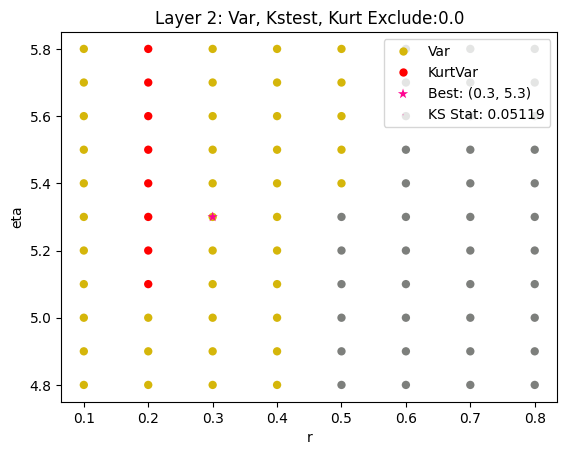

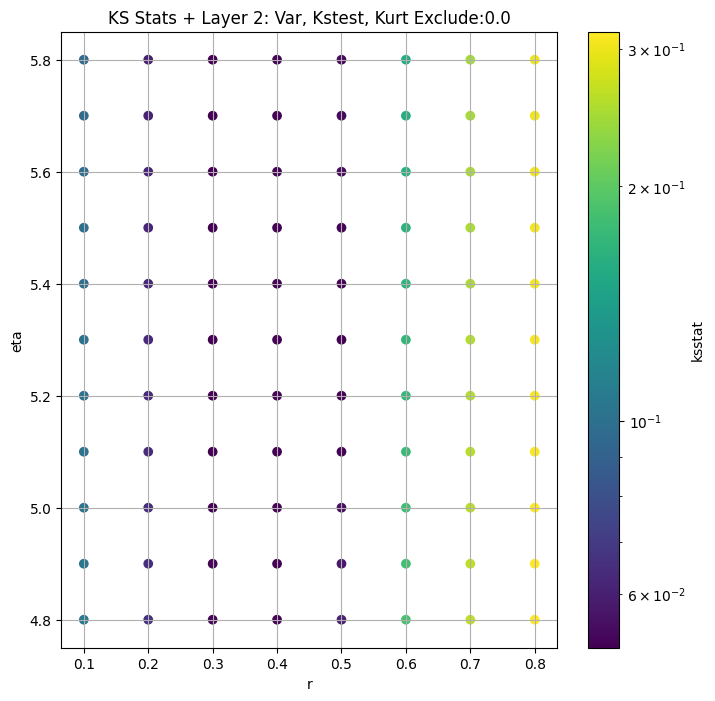

####
Layer  3


100%|██████████| 12760/12760 [00:10<00:00, 1256.29it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.03168984112485784 4835927.0


100%|██████████| 12760/12760 [00:09<00:00, 1354.30it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.032208791383060265 4529936.5


100%|██████████| 12760/12760 [00:10<00:00, 1241.32it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.03287687010904072 4323602.5


100%|██████████| 12760/12760 [00:10<00:00, 1260.62it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.03350961288776855 4158965.5


100%|██████████| 12760/12760 [00:09<00:00, 1276.04it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.034299018632308775 4013843.2


100%|██████████| 12760/12760 [00:10<00:00, 1235.37it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.03474371862304615 3766787.0


100%|██████████| 12760/12760 [00:09<00:00, 1281.33it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.03599974195833072 3554410.0


100%|██████████| 12760/12760 [00:09<00:00, 1339.11it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.03722288053691153 3367986.8


100%|██████████| 12760/12760 [00:09<00:00, 1351.07it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.03907428920435996 3201553.0


100%|██████████| 12760/12760 [00:10<00:00, 1249.51it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.041169640134065044 3048154.0


100%|██████████| 12760/12760 [00:10<00:00, 1246.58it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.05247218165396028 2651824.2
Number of samples: 12832, Without approximation : 12832.0


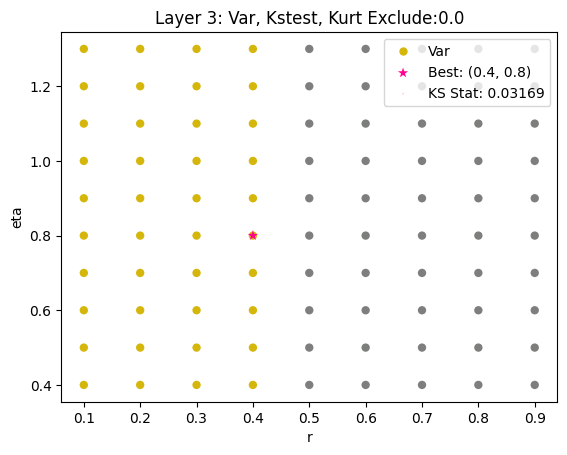

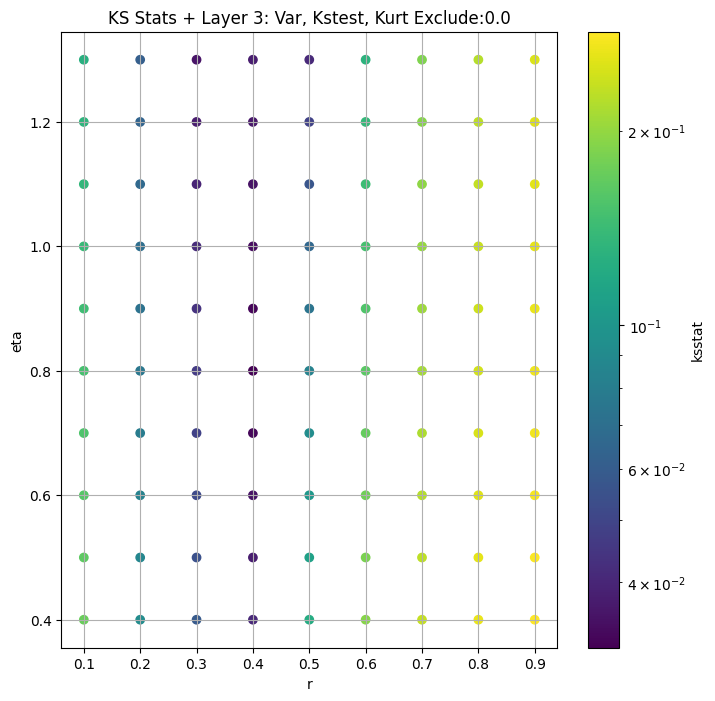

####
Layer  4


100%|██████████| 12760/12760 [00:34<00:00, 366.88it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.02430835098898909 1034581.4


100%|██████████| 12760/12760 [00:34<00:00, 364.73it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.02398802219904106 1004630.06


100%|██████████| 12760/12760 [00:34<00:00, 369.07it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.025180148308924677 982500.7


100%|██████████| 12760/12760 [00:37<00:00, 336.23it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.024872820093680026 963931.6


100%|██████████| 12760/12760 [00:35<00:00, 358.95it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.025143437927668155 947335.06


100%|██████████| 12760/12760 [00:34<00:00, 368.83it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.025772786065141162 918112.7


100%|██████████| 12760/12760 [00:34<00:00, 369.38it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.026081364370769466 892175.2


100%|██████████| 12760/12760 [00:34<00:00, 366.38it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.025491509353867403 868751.56


100%|██████████| 12760/12760 [00:34<00:00, 368.96it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.027050347698438726 847312.06


100%|██████████| 12760/12760 [00:35<00:00, 362.23it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.02652946701687814 827537.3


100%|██████████| 12760/12760 [00:35<00:00, 359.47it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.028780581561304863 775472.4
Number of samples: 51328, Without approximation : 51328.0


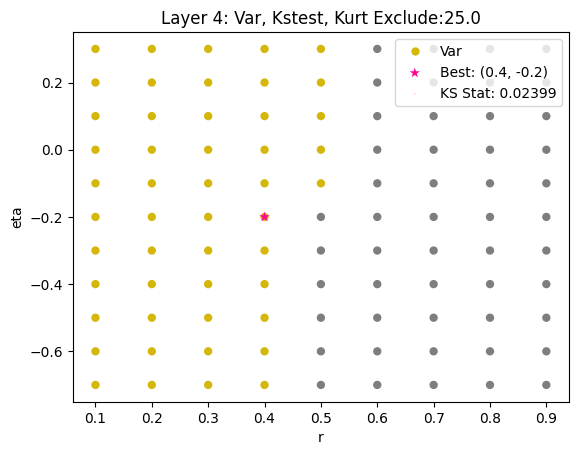

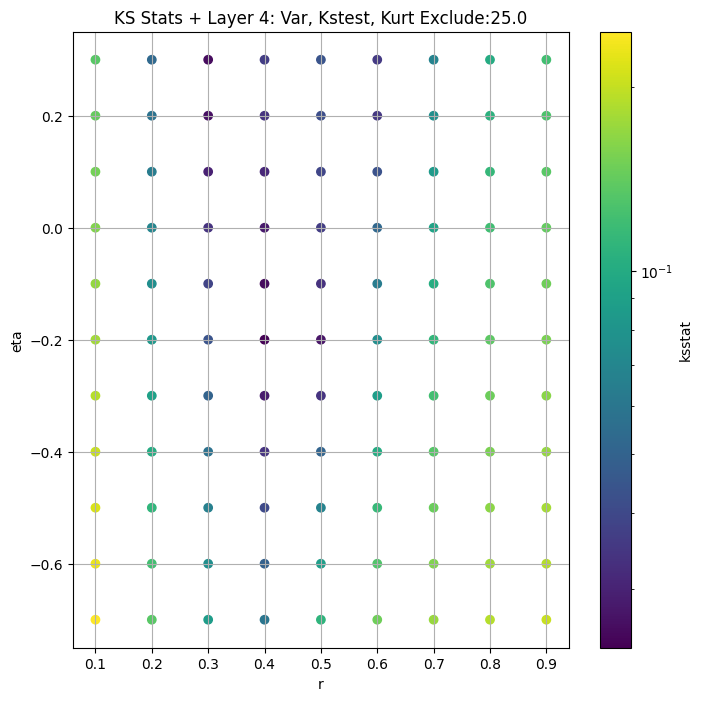

####
Layer  5


100%|██████████| 12760/12760 [01:22<00:00, 155.28it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.01929680441717474 198319.44


100%|██████████| 12760/12760 [01:07<00:00, 187.89it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.01909375021845855 194299.33


100%|██████████| 12760/12760 [01:08<00:00, 186.74it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.01893449157408439 191227.89


100%|██████████| 12760/12760 [01:08<00:00, 186.53it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.018960100407949654 188539.3


100%|██████████| 12760/12760 [01:06<00:00, 192.36it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.0188228522567504 186090.38


100%|██████████| 12760/12760 [01:07<00:00, 189.34it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.018810945055129313 181692.84


100%|██████████| 12760/12760 [01:12<00:00, 174.85it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.018799891708117633 177747.7


100%|██████████| 12760/12760 [01:09<00:00, 183.25it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.019057936928331354 174157.97


100%|██████████| 12760/12760 [01:13<00:00, 174.78it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.02039321285289819 170855.48


100%|██████████| 12760/12760 [01:07<00:00, 188.18it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.021660817718913372 167769.42


100%|██████████| 12760/12760 [01:06<00:00, 190.49it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.02138474206303398 159428.61
Number of samples: 100000, Without approximation : 205312.0


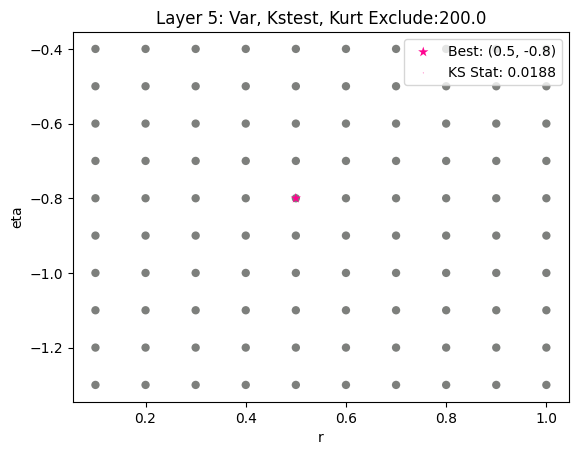

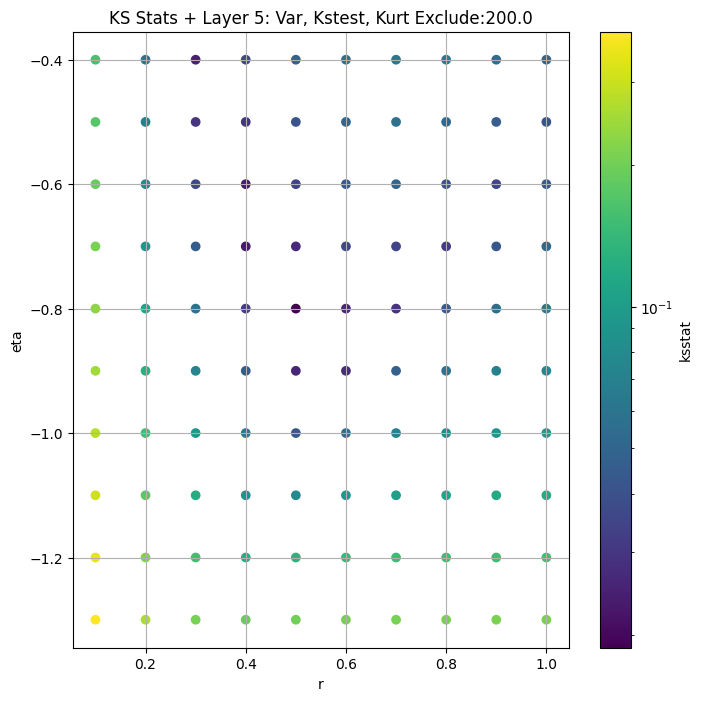

####
Layer  6


100%|██████████| 12760/12760 [01:13<00:00, 173.31it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.02565718413342377 35802.293


100%|██████████| 12760/12760 [01:06<00:00, 190.76it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.025545913170803014 34775.91


100%|██████████| 12760/12760 [01:10<00:00, 179.87it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.025459607267752482 34007.574


100%|██████████| 12760/12760 [01:06<00:00, 191.18it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.02560865982586802 33346.047


100%|██████████| 12760/12760 [01:08<00:00, 186.37it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.025910502559621795 32749.402


100%|██████████| 12760/12760 [01:09<00:00, 183.93it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.02645932014597452 31700.84


100%|██████████| 12760/12760 [01:08<00:00, 184.96it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.026534967063483683 30781.982


100%|██████████| 12760/12760 [01:07<00:00, 190.24it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.026658885314895686 29952.537


100%|██████████| 12760/12760 [01:10<00:00, 181.02it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.026565769868964362 29195.379


100%|██████████| 12760/12760 [01:07<00:00, 189.86it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.026476507721754805 28495.057


100%|██████████| 12760/12760 [01:09<00:00, 182.84it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.025854118523732594 26654.842
Number of samples: 100000, Without approximation : 821248.0


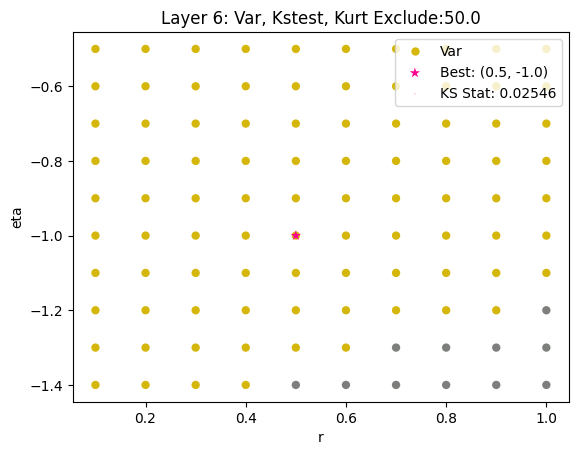

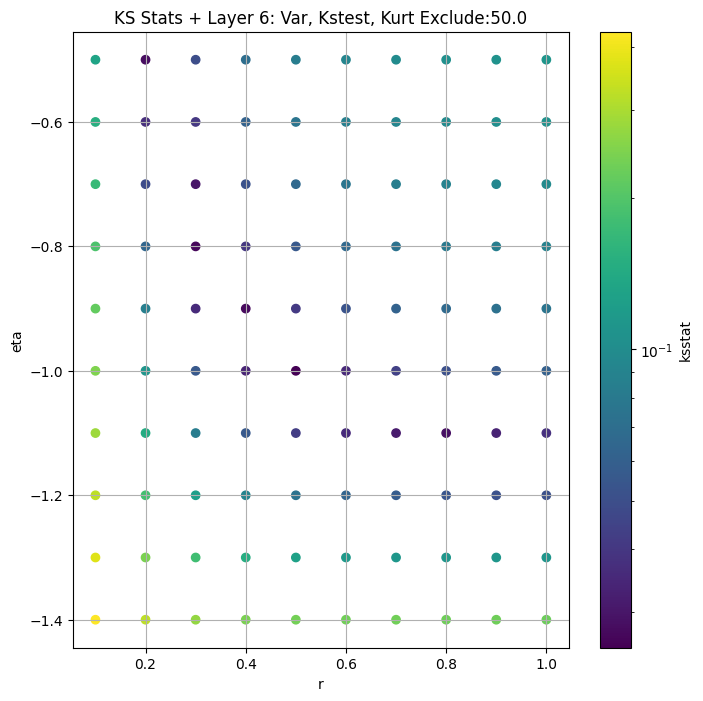

####
Layer  7


100%|██████████| 12760/12760 [01:08<00:00, 186.47it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.03732095428739024 6274.3115


100%|██████████| 12760/12760 [01:08<00:00, 186.21it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.03731359562249836 6031.2974


100%|██████████| 12760/12760 [01:07<00:00, 187.68it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.03730800620161234 5856.02


100%|██████████| 12760/12760 [01:07<00:00, 188.87it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.037303036214803575 5706.504


100%|██████████| 12760/12760 [01:09<00:00, 184.22it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.03729999999992928 5574.027


100%|██████████| 12760/12760 [01:08<00:00, 185.93it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.037299999999927835 5344.6343


100%|██████████| 12760/12760 [01:10<00:00, 180.88it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.03734320341472719 5147.4146


100%|██████████| 12760/12760 [01:22<00:00, 154.73it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.0373371270702173 4971.6094


100%|██████████| 12760/12760 [01:09<00:00, 182.30it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.03733134112141351 4812.443


100%|██████████| 12760/12760 [01:08<00:00, 186.18it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.03732579096688421 4666.836


100%|██████████| 12760/12760 [01:12<00:00, 177.10it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.037310248009945646 4292.497
Number of samples: 100000, Without approximation : 3284992.0


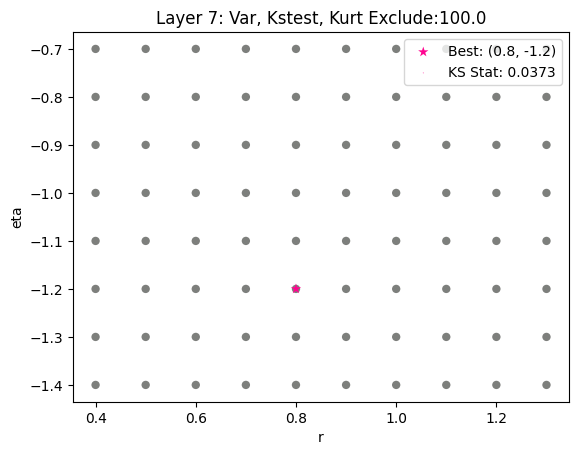

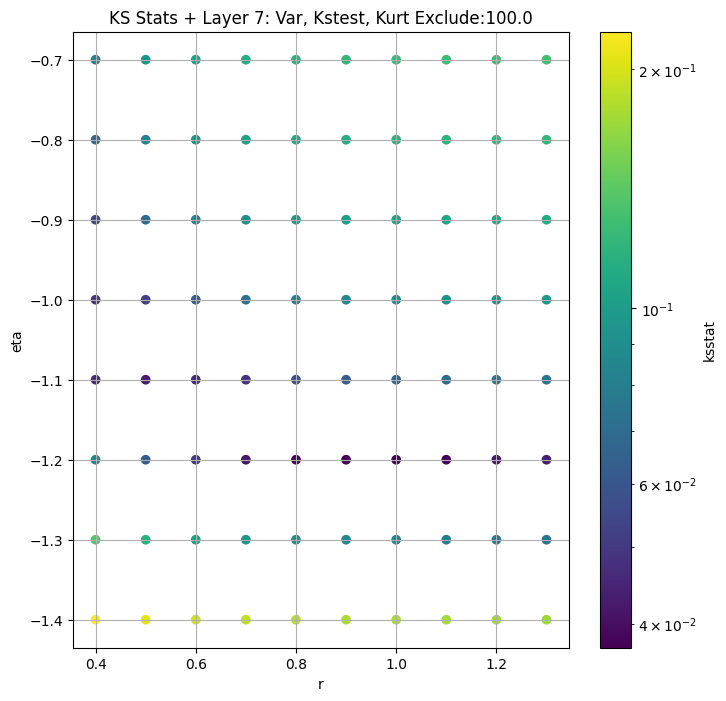

####
Layer  8


100%|██████████| 12760/12760 [01:09<00:00, 183.72it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.03701999999993649 1189.42


100%|██████████| 12760/12760 [01:13<00:00, 173.82it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.037019999999946485 1126.5498


100%|██████████| 12760/12760 [01:11<00:00, 177.48it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.037019999999945374 1082.4728


100%|██████████| 12760/12760 [01:07<00:00, 188.55it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.037019999999944486 1045.7869


100%|██████████| 12760/12760 [01:08<00:00, 185.62it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.03701999999994349 1013.89667


100%|██████████| 12760/12760 [01:09<00:00, 182.84it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.037019999999926945 959.5205


100%|██████████| 12760/12760 [03:27<00:00, 61.44it/s] 


Finding Minimum after computing 12760 CDFs
8 200 0.03701999999992511 913.6019


100%|██████████| 12760/12760 [02:42<00:00, 78.35it/s] 


Finding Minimum after computing 12760 CDFs
8 250 0.03701999999992339 873.6547


100%|██████████| 12760/12760 [02:08<00:00, 99.40it/s] 


Finding Minimum after computing 12760 CDFs
8 300 0.03701999999992184 838.1975


100%|██████████| 12760/12760 [02:44<00:00, 77.39it/s] 


Finding Minimum after computing 12760 CDFs
8 350 0.03701999999992028 806.28076


100%|██████████| 12760/12760 [04:37<00:00, 45.95it/s] 


Finding Minimum after computing 12760 CDFs
8 500 0.037019999999915953 725.8997
Number of samples: 100000, Without approximation : 13139968.0


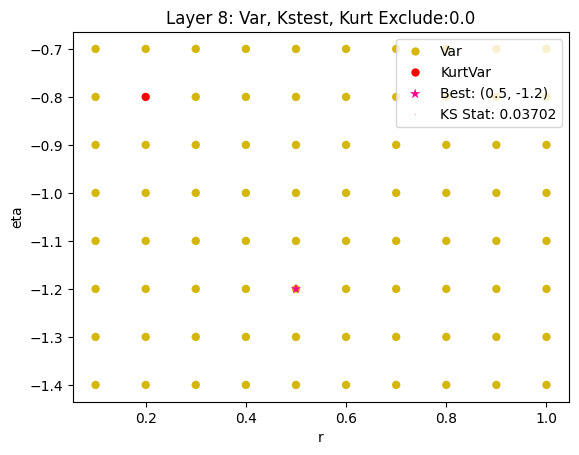

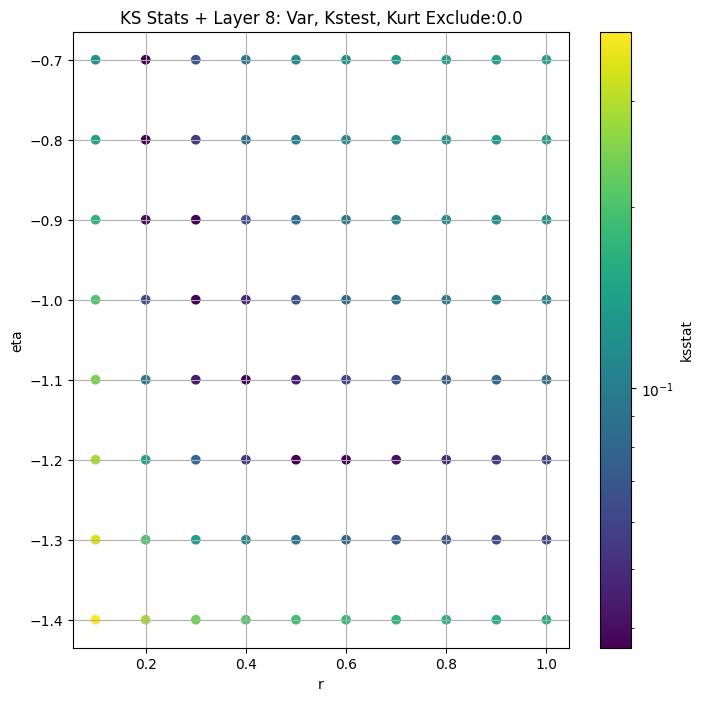

####
Layer  9


100%|██████████| 12760/12760 [01:12<00:00, 175.62it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.06568999999682457 256.76007


100%|██████████| 12760/12760 [01:15<00:00, 169.57it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.06568999999671626 240.095


100%|██████████| 12760/12760 [01:33<00:00, 135.83it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.06568999999663522 228.66408


100%|██████████| 12760/12760 [01:11<00:00, 179.46it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.06568999999656366 219.25693


100%|██████████| 12760/12760 [01:31<00:00, 138.83it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.06568999999649844 211.14964


100%|██████████| 12760/12760 [01:34<00:00, 134.55it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.06568999999637981 197.53806


100%|██████████| 12760/12760 [08:15<00:00, 25.77it/s]  


Finding Minimum after computing 12760 CDFs
9 200 0.06568999999682523 186.28592


100%|██████████| 12760/12760 [02:21<00:00, 90.39it/s] 


Finding Minimum after computing 12760 CDFs
9 250 0.06568999999673991 176.66705


100%|██████████| 12760/12760 [01:25<00:00, 149.71it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.06568999999665948 168.25345


100%|██████████| 12760/12760 [02:28<00:00, 85.81it/s] 


Finding Minimum after computing 12760 CDFs
9 350 0.06568999999658276 160.7824


100%|██████████| 12760/12760 [01:22<00:00, 153.77it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.06568999999636893 142.40851
Number of samples: 100000, Without approximation : 52559872.0


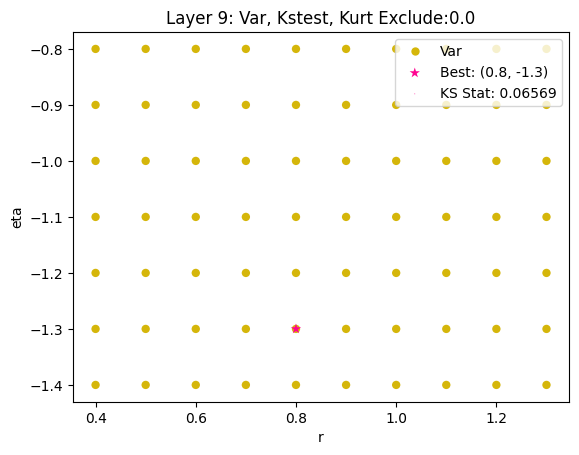

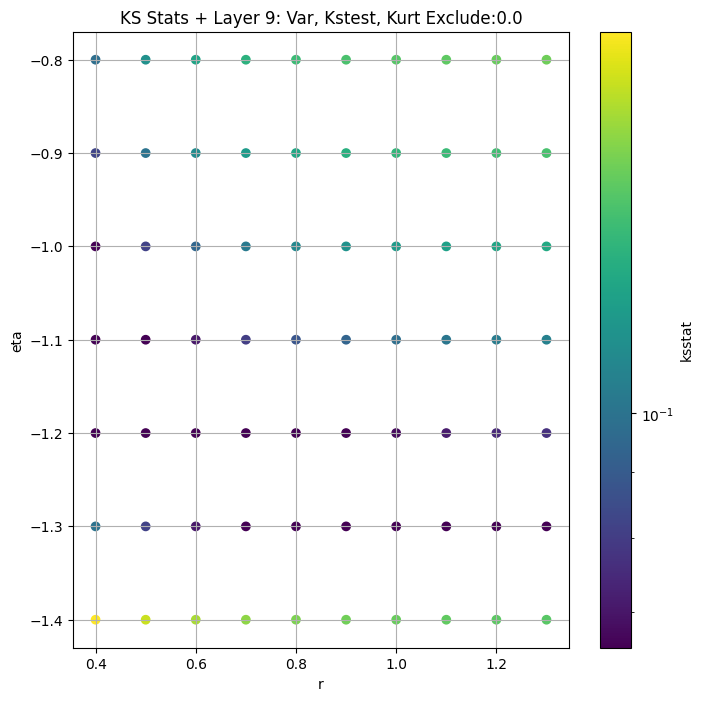

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.167439e+07  2.007571e+07  2.336055e+07   0.787101    0.382352   
3      4.835927e+06  4.598368e+06  5.083178e+06   1.799972    1.476695   
4      1.034581e+06  9.740716e+05  1.099110e+06   3.519323    2.922325   
5      1.983194e+05  1.846769e+05  2.125875e+05   5.446397    4.604024   
6      3.580229e+04  3.279927e+04  3.896280e+04   9.192647    7.647657   
7      6.274311e+03  5.654861e+03  6.950309e+03  14.085468   11.431098   
8      1.189420e+03  1.047309e+03  1.345900e+03  21.680420   17.037355   
9      2.567601e+02  2.218154e+02  2.951868e+02  28.972792   22.108063   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        1.240317         3208.0             0.051189        0.3          5.3   
3        2.147720        12832.0             0.031690        0.4          0.8   
4        4.190051        51328.0             0.023988        0.4         -0.2   
5        6.386241       205312.0             0.018800        0.5         -0.8   
6       10.959983       821248.0             0.025460        0.5         -1.0   
7       17.666815      3284992.0             0.037300        0.8         -1.2   
8       27.775066     13139968.0             0.037020        0.5         -1.2   
9       38.456100     52559872.0             0.065690        0.8         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2         557.706657                     0.0        2.167439e+07   
3       45483.846162                     0.0        4.835927e+06   
4       32507.165768                    25.0        1.004630e+06   
5       52901.102121                   200.0        1.777477e+05   
6       17003.787109                    50.0        3.400757e+04   
7       14737.066683                   100.0        5.574027e+03   
8        1238.979212                     0.0        1.189420e+03   
9        1050.421546                     0.0        2.567601e+02   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.023925  
3                     0.011976  
4                     0.005991  
5                     0.002996  
6                     0.001498  
7                     0.000749  
8                     0.000375  
9                     0.000187

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 702/702 [00:00<00:00, 1454.30it/s]


Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.0739785976768722, var: 14501763.0


100%|██████████| 702/702 [00:00<00:00, 2859.16it/s]


Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.0666253575178718, var: 15638571.0


100%|██████████| 702/702 [00:00<00:00, 3780.86it/s]


Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.05876981048306129, var: 16977836.0


100%|██████████| 702/702 [00:00<00:00, 3174.63it/s]


Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.05119474155805004, var: 18715304.0


100%|██████████| 702/702 [00:00<00:00, 3431.19it/s]


Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.05118895449643368, var: 21674388.0
Number of samples: 3208, Without approximation : 3208.0


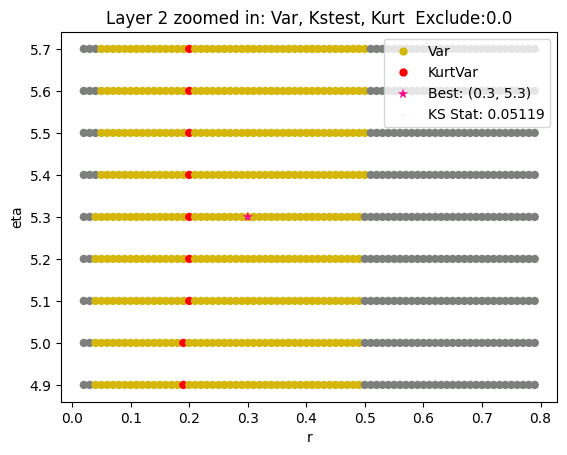

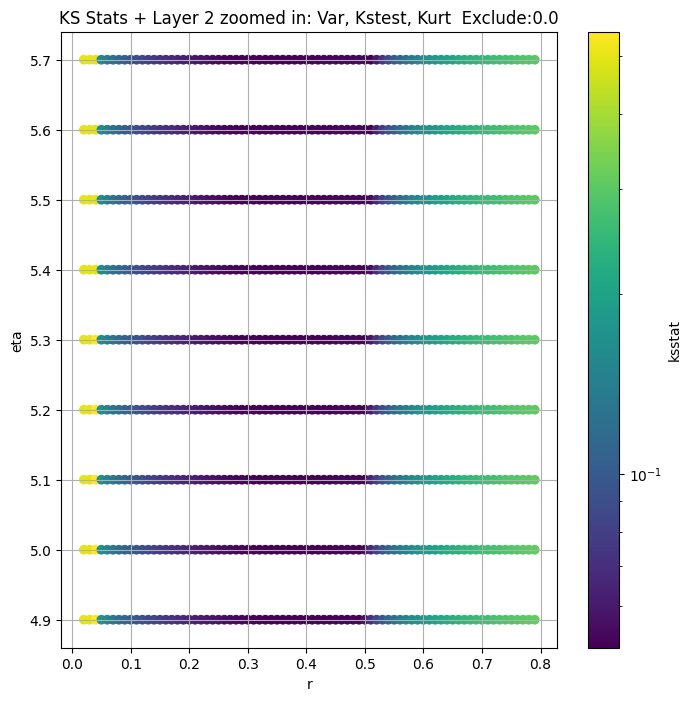

Layer 3


100%|██████████| 792/792 [00:01<00:00, 524.44it/s]


Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.03492149896662755, var: 4013843.25


100%|██████████| 792/792 [00:00<00:00, 1275.38it/s]


Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.033218200735454395, var: 4158965.5


100%|██████████| 792/792 [00:00<00:00, 910.08it/s] 


Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.03261690941789047, var: 4323602.5


100%|██████████| 792/792 [00:00<00:00, 1338.81it/s]


Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.031876106794494485, var: 4529936.5


100%|██████████| 792/792 [00:00<00:00, 1346.67it/s]


Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.03168544655256844, var: 4835927.0
Number of samples: 12832, Without approximation : 12832.0


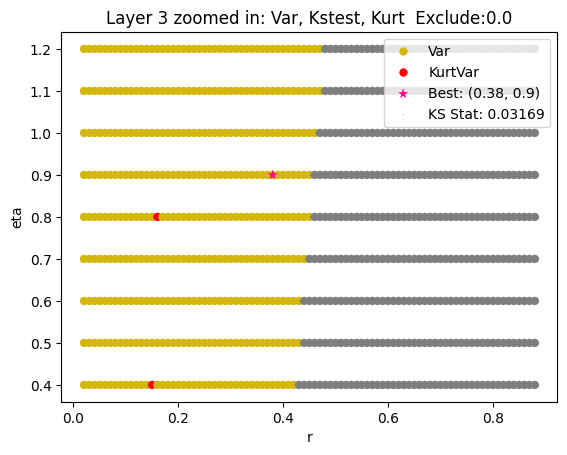

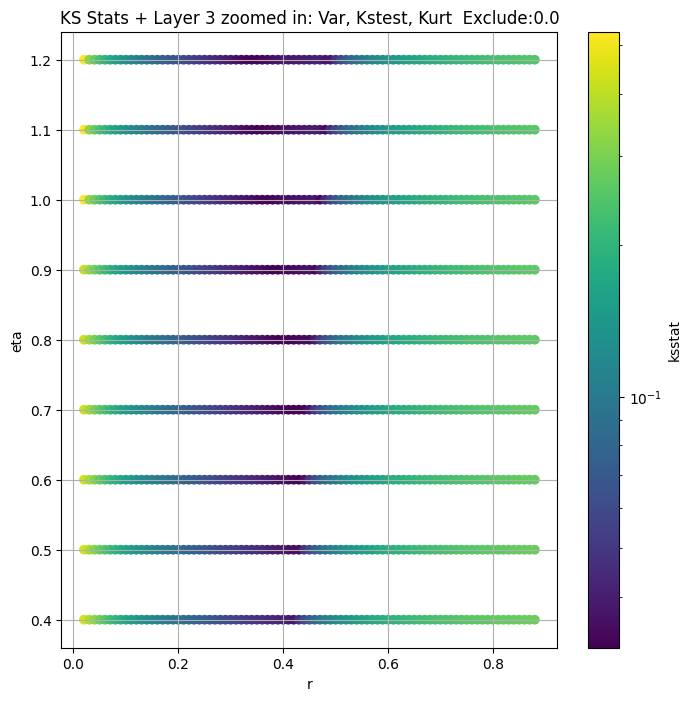

Layer 4


100%|██████████| 1384/1384 [00:04<00:00, 303.05it/s]


Finding Minimum after computing 1384 CDFs
layer 4, 25.0 + 100 = 125, ksstat: 0.024604214592111373, var: 932153.9375


100%|██████████| 1384/1384 [00:03<00:00, 359.19it/s]


Finding Minimum after computing 1384 CDFs
layer 4, 25.0 + 75 = 100, ksstat: 0.024300995239805, var: 947335.0625


100%|██████████| 1384/1384 [00:03<00:00, 357.05it/s]


Finding Minimum after computing 1384 CDFs
layer 4, 25.0 + 50 = 75, ksstat: 0.023974576005270254, var: 963931.625


100%|██████████| 1384/1384 [00:03<00:00, 359.15it/s]


Finding Minimum after computing 1384 CDFs
layer 4, 25.0 + 25 = 50, ksstat: 0.023892520473594803, var: 982500.6875


100%|██████████| 1384/1384 [00:03<00:00, 355.24it/s]


Finding Minimum after computing 1384 CDFs
layer 4, 25.0 + 0 = 25, ksstat: 0.023832048936858474, var: 1004630.0625


100%|██████████| 1384/1384 [00:03<00:00, 359.92it/s]


Finding Minimum after computing 1384 CDFs
layer 4, 25.0 + -25 = 0, ksstat: 0.023186148830845688, var: 1034581.375
Number of samples: 51328, Without approximation : 51328.0


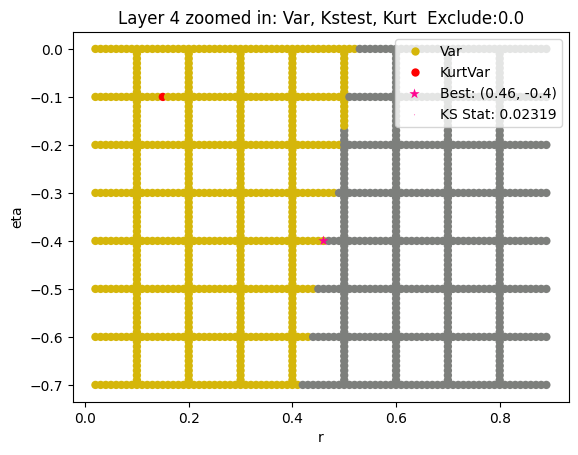

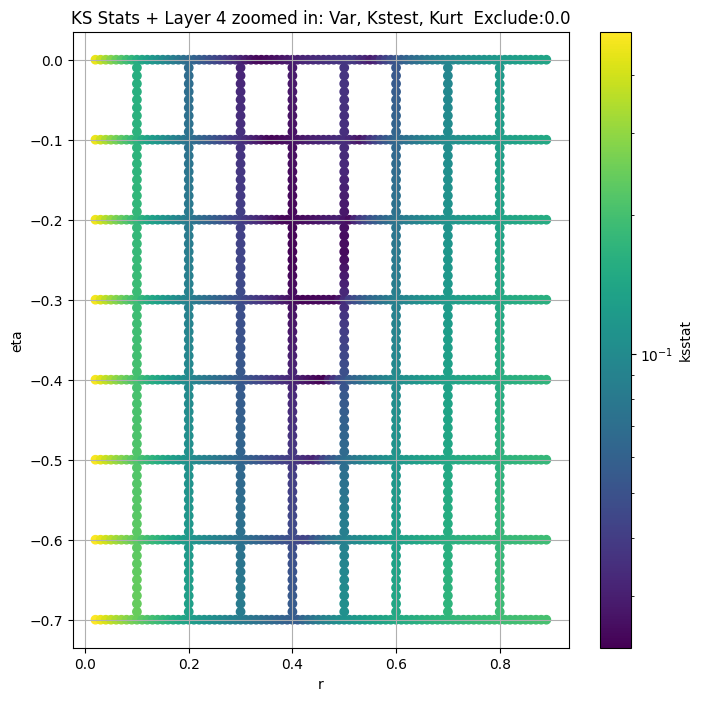

Layer 5


100%|██████████| 1692/1692 [00:10<00:00, 161.18it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 200.0 + 100 = 300, ksstat: 0.01873982199675206, var: 170855.484375


100%|██████████| 1692/1692 [00:09<00:00, 186.28it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 200.0 + 75 = 275, ksstat: 0.01873982199675206, var: 172474.625


100%|██████████| 1692/1692 [00:10<00:00, 154.69it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 200.0 + 50 = 250, ksstat: 0.01873982199675206, var: 174157.96875


100%|██████████| 1692/1692 [00:10<00:00, 163.89it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 200.0 + 25 = 225, ksstat: 0.01873982199675206, var: 175913.421875


100%|██████████| 1692/1692 [00:09<00:00, 170.08it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 200.0 + 0 = 200, ksstat: 0.01873982199675206, var: 177747.703125


100%|██████████| 1692/1692 [00:09<00:00, 173.24it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 200.0 + -25 = 175, ksstat: 0.0187398070352347, var: 179673.453125


100%|██████████| 1692/1692 [00:09<00:00, 181.52it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 200.0 + -50 = 150, ksstat: 0.018709678855359402, var: 181692.84375


100%|██████████| 1692/1692 [00:11<00:00, 151.11it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 200.0 + -75 = 125, ksstat: 0.018691670905305047, var: 183819.421875


100%|██████████| 1692/1692 [00:12<00:00, 130.78it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 200.0 + -100 = 100, ksstat: 0.01867416693029611, var: 186090.375
Number of samples: 100000, Without approximation : 205312.0


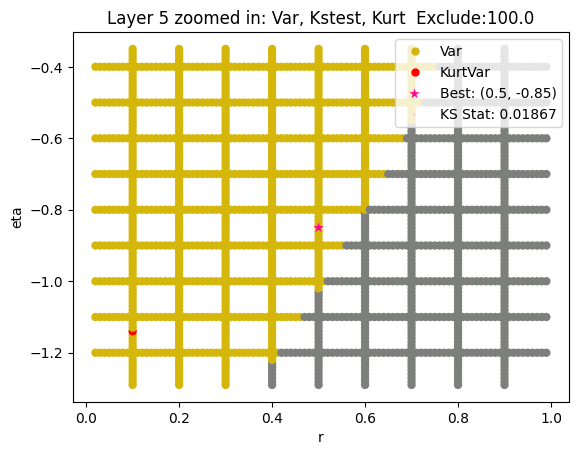

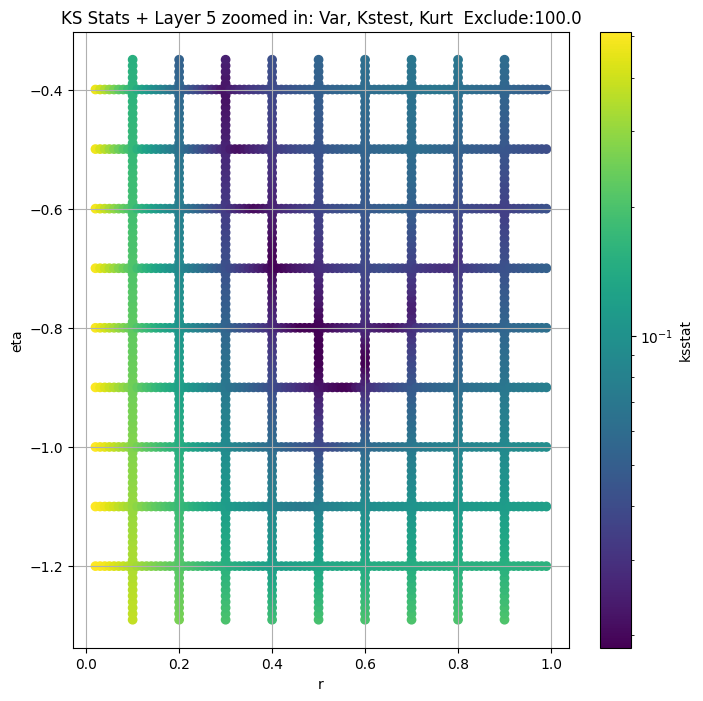

Layer 6


100%|██████████| 1656/1656 [00:10<00:00, 164.22it/s]


Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + 100 = 150, ksstat: 0.02546965374162824, var: 31700.83984375


100%|██████████| 1656/1656 [00:10<00:00, 159.84it/s]


Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + 75 = 125, ksstat: 0.025562347263095253, var: 32205.298828125


100%|██████████| 1656/1656 [00:08<00:00, 184.45it/s]


Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + 50 = 100, ksstat: 0.02547439338607832, var: 32749.40234375


100%|██████████| 1656/1656 [00:09<00:00, 170.64it/s]


Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + 25 = 75, ksstat: 0.025543883174637683, var: 33346.046875


100%|██████████| 1656/1656 [00:10<00:00, 159.05it/s]


Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + 0 = 50, ksstat: 0.025459607267752482, var: 34007.57421875


100%|██████████| 1656/1656 [00:09<00:00, 175.44it/s]


Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + -25 = 25, ksstat: 0.025545913170803014, var: 34775.91015625


100%|██████████| 1656/1656 [00:11<00:00, 150.20it/s]


Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + -50 = 0, ksstat: 0.025492403706441846, var: 35802.29296875
Number of samples: 100000, Without approximation : 821248.0


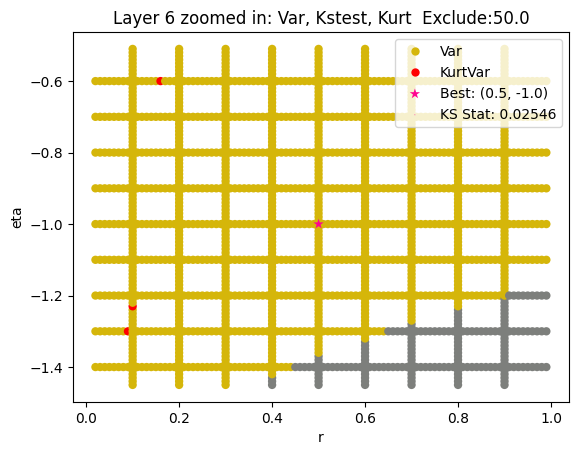

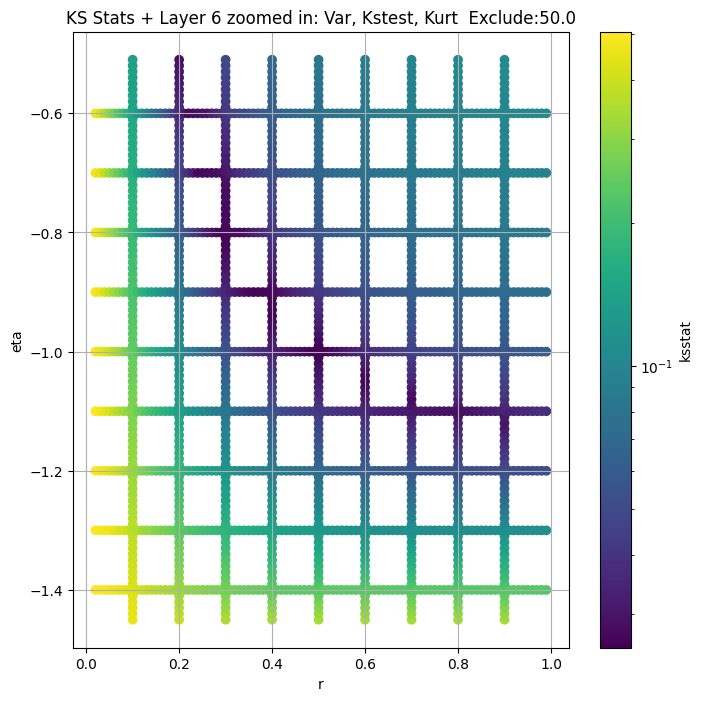

Layer 7


100%|██████████| 1305/1305 [00:10<00:00, 121.24it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + 100 = 200, ksstat: 0.037299999999927946, var: 5147.41455078125


100%|██████████| 1305/1305 [00:09<00:00, 133.84it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + 75 = 175, ksstat: 0.03729999999992828, var: 5242.92724609375


100%|██████████| 1305/1305 [00:08<00:00, 155.47it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + 50 = 150, ksstat: 0.037299999999927835, var: 5344.63427734375


100%|██████████| 1305/1305 [00:09<00:00, 133.20it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + 25 = 125, ksstat: 0.03729999999979566, var: 5454.34228515625


100%|██████████| 1305/1305 [00:09<00:00, 142.32it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + 0 = 100, ksstat: 0.03729999999979783, var: 5574.02685546875


100%|██████████| 1305/1305 [00:10<00:00, 130.20it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + -25 = 75, ksstat: 0.03729999999980027, var: 5706.50390625


100%|██████████| 1305/1305 [00:07<00:00, 164.88it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + -50 = 50, ksstat: 0.03729999999979611, var: 5856.02001953125


100%|██████████| 1305/1305 [00:08<00:00, 150.90it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + -75 = 25, ksstat: 0.03729999999979927, var: 6031.29736328125


100%|██████████| 1305/1305 [00:07<00:00, 183.05it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 100.0 + -100 = 0, ksstat: 0.03729999999976563, var: 6274.3115234375
Number of samples: 100000, Without approximation : 3284992.0


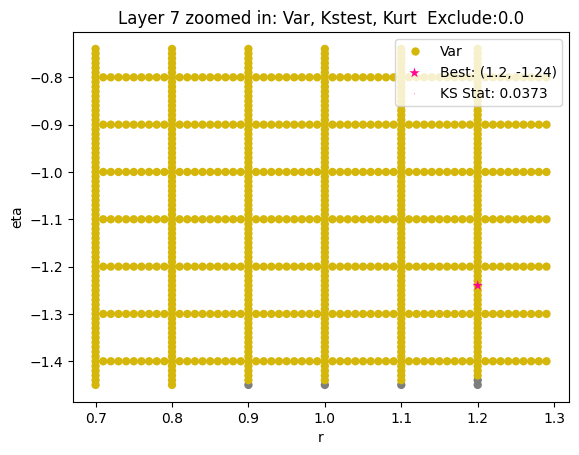

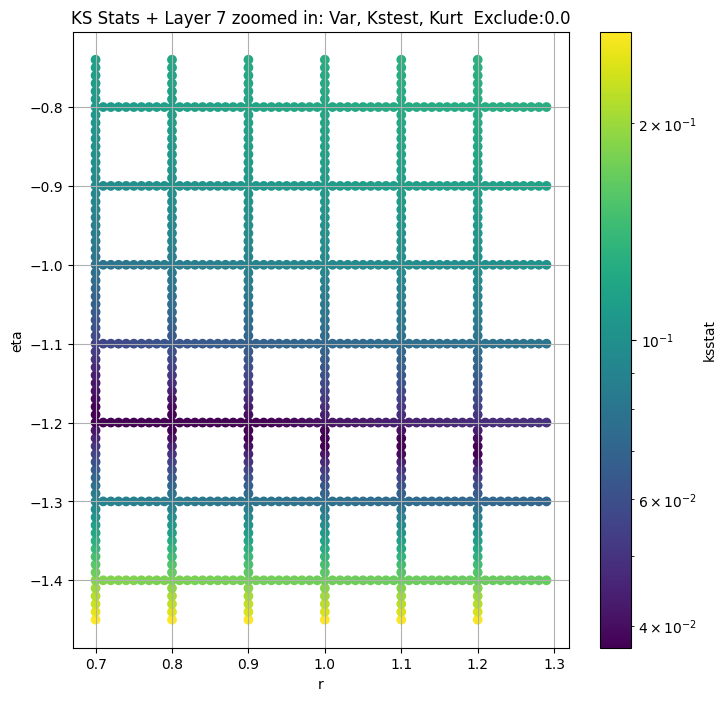

Layer 8


100%|██████████| 1298/1298 [00:07<00:00, 183.98it/s]


Finding Minimum after computing 1298 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.03701999999969524, var: 1013.8966674804688


100%|██████████| 1298/1298 [00:07<00:00, 170.48it/s]


Finding Minimum after computing 1298 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.03701999999969996, var: 1045.786865234375


100%|██████████| 1298/1298 [00:07<00:00, 180.53it/s]


Finding Minimum after computing 1298 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.03701999999966016, var: 1082.4727783203125


100%|██████████| 1298/1298 [00:07<00:00, 183.09it/s]


Finding Minimum after computing 1298 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.037019999999666875, var: 1126.5498046875


100%|██████████| 1298/1298 [00:07<00:00, 185.39it/s]


Finding Minimum after computing 1298 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.03701999999967581, var: 1189.4200439453125
Number of samples: 100000, Without approximation : 13139968.0


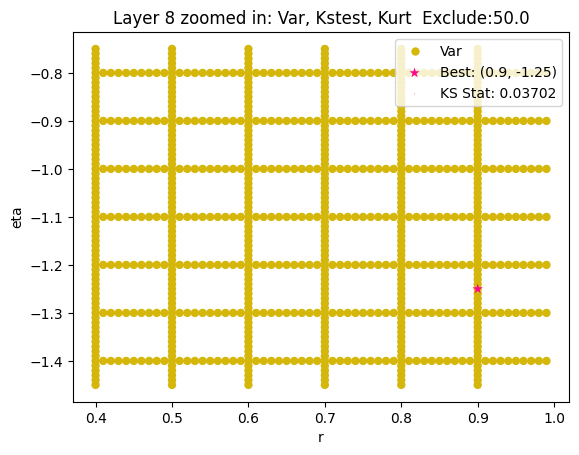

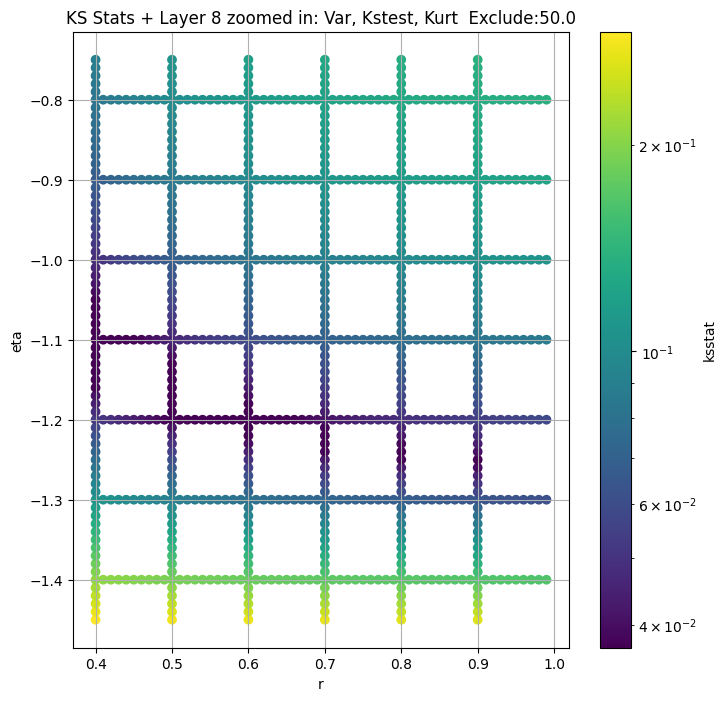

Layer 9


100%|██████████| 1125/1125 [00:07<00:00, 150.78it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.06568999999634256, var: 211.14964294433594


100%|██████████| 1125/1125 [00:07<00:00, 145.18it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.06568999999634001, var: 219.25692749023438


100%|██████████| 1125/1125 [00:08<00:00, 126.90it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.06568999999634001, var: 228.66407775878906


100%|██████████| 1125/1125 [00:07<00:00, 147.53it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.06568999999634695, var: 240.09500122070312


100%|██████████| 1125/1125 [00:07<00:00, 144.62it/s]


Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.06568999999633435, var: 256.76007080078125
Number of samples: 100000, Without approximation : 52559872.0


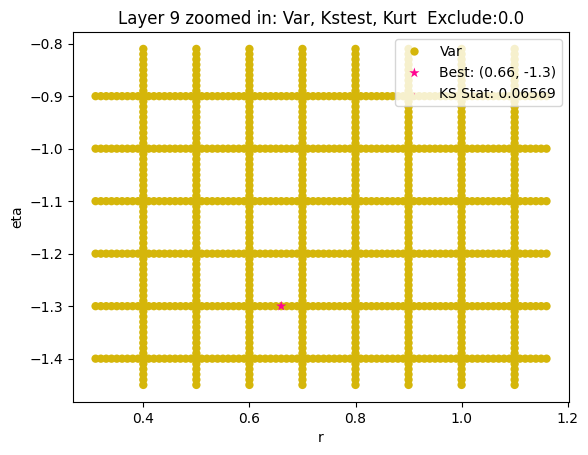

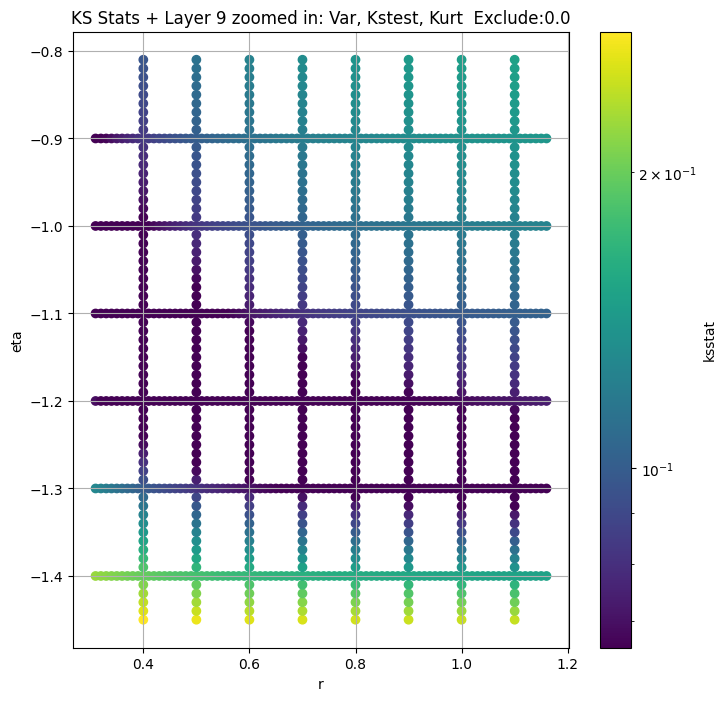

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.167439e+07  2.007571e+07  2.336055e+07   0.787101    0.382352   
3      4.835927e+06  4.598368e+06  5.083178e+06   1.799972    1.476695   
4      1.034581e+06  9.740716e+05  1.099110e+06   3.519323    2.922325   
5      1.983194e+05  1.846769e+05  2.125875e+05   5.446397    4.604024   
6      3.580229e+04  3.279927e+04  3.896280e+04   9.192647    7.647657   
7      6.274311e+03  5.654861e+03  6.950309e+03  14.085468   11.431098   
8      1.189420e+03  1.047309e+03  1.345900e+03  21.680420   17.037355   
9      2.567601e+02  2.218154e+02  2.951868e+02  28.972792   22.108063   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        1.240317         3208.0             0.051189        0.3          5.3   
3        2.147720        12832.0             0.031690        0.4          0.8   
4        4.190051        51328.0             0.023988        0.4         -0.2   
5        6.386241       205312.0             0.018800        0.5         -0.8   
6       10.959983       821248.0             0.025460        0.5         -1.0   
7       17.666815      3284992.0             0.037300        0.8         -1.2   
8       27.775066     13139968.0             0.037020        0.5         -1.2   
9       38.456100     52559872.0             0.065690        0.8         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2         557.706657                     0.0        2.167439e+07   
3       45483.846162                     0.0        4.835927e+06   
4       32507.165768                    25.0        1.034581e+06   
5       52901.102121                   200.0        1.860904e+05   
6       17003.787109                    50.0        3.400757e+04   
7       14737.066683                   100.0        6.274312e+03   
8        1238.979212                     0.0        1.082473e+03   
9        1050.421546                     0.0        2.567601e+02   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.023925          0.051189    0.30      5.30   
3                     0.011976          0.031685    0.38      0.90   
4                     0.005991          0.023186    0.46     -0.40   
5                     0.002996          0.018674    0.50     -0.85   
6                     0.001498          0.025460    0.50     -1.00   
7                     0.000749          0.037300    1.20     -1.24   
8                     0.000375          0.037020    0.90     -1.25   
9                     0.000187          0.065690    0.66     -1.30   

          best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                   
2         557.706657                  0.0          675  
3       27850.944431                  0.0         1804  
4      100000.000000                  0.0         3609  
5       62237.583612                100.0         5413  
6       17003.787109                 50.0         2706  
7       27185.819943                  0.0         1353  
8        3954.746444                 50.0         1353  
9         811.726249                  0.0          424

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

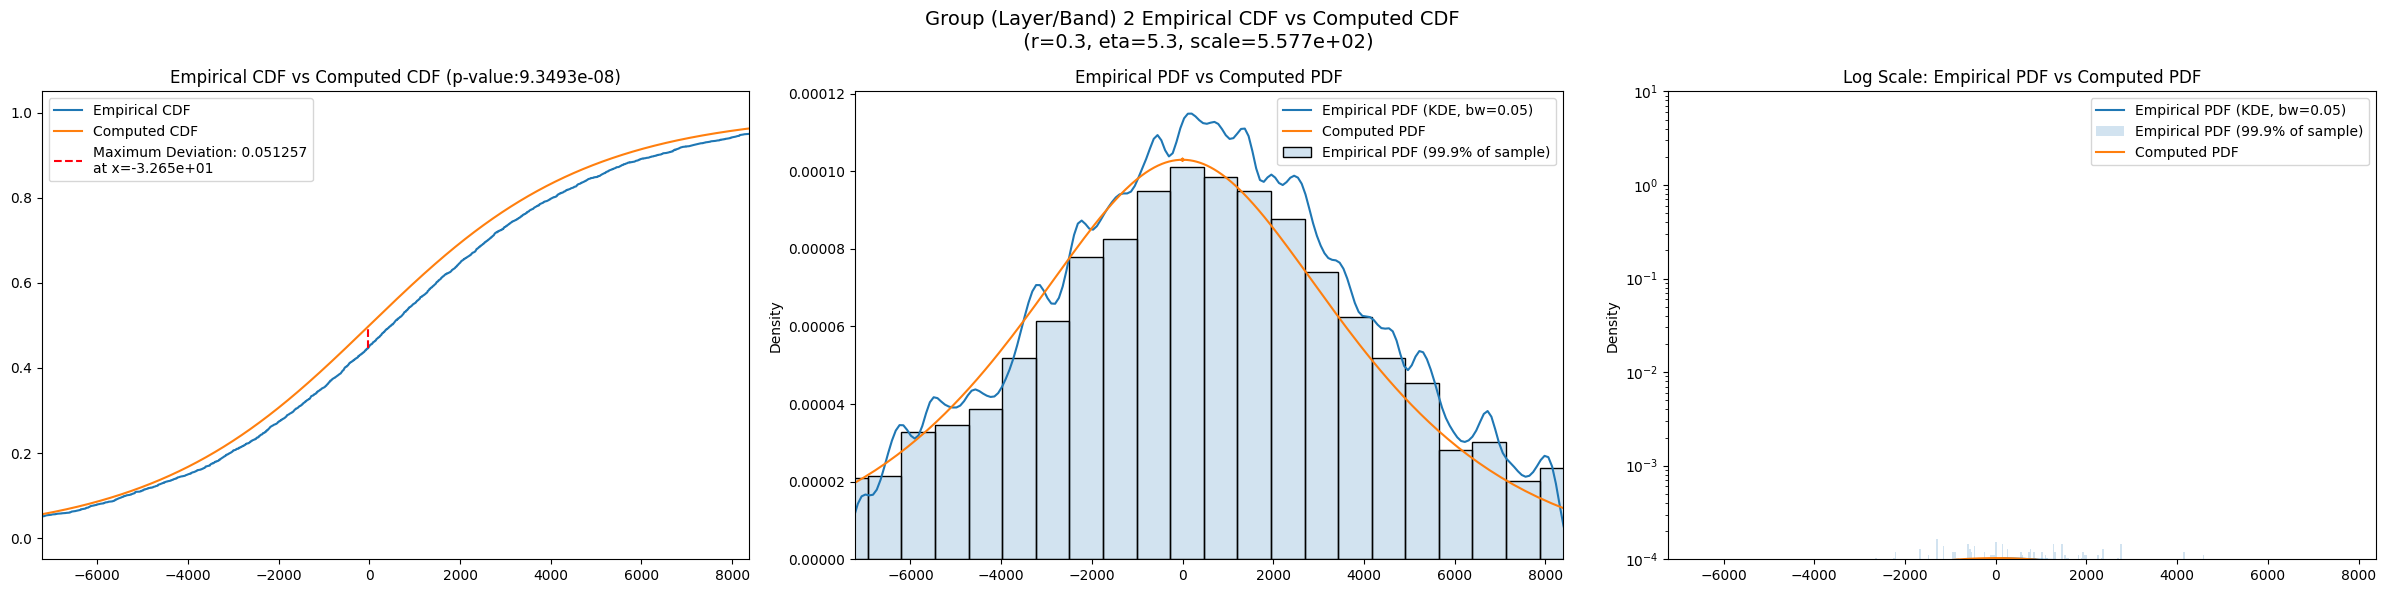

/Users/brandonmarks/opt/anaconda3/envs/HBMV/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


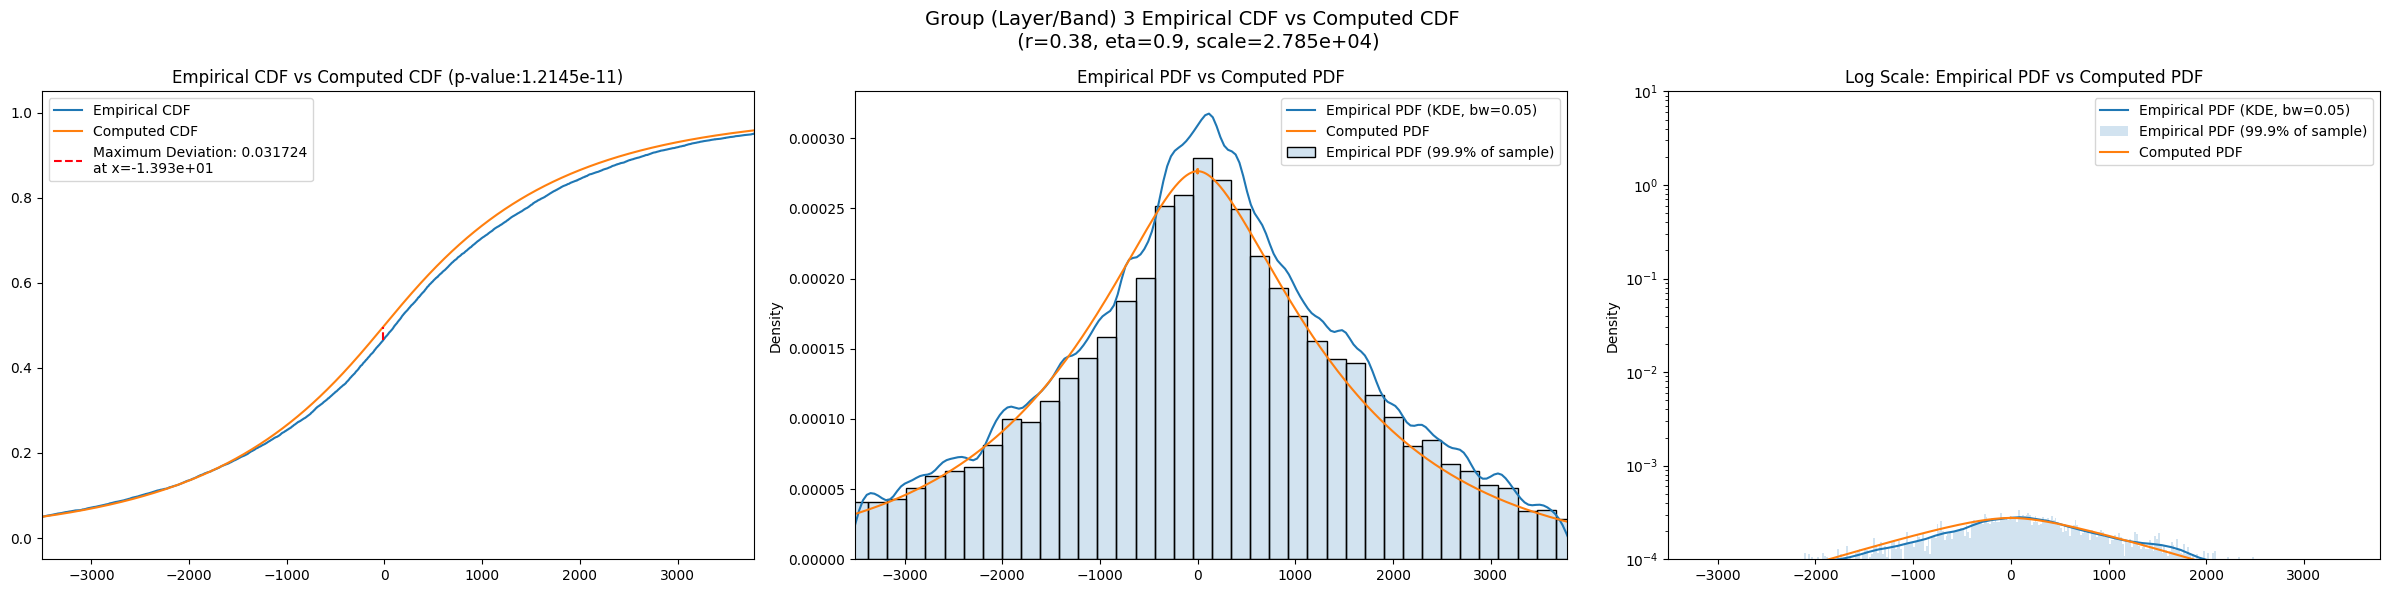

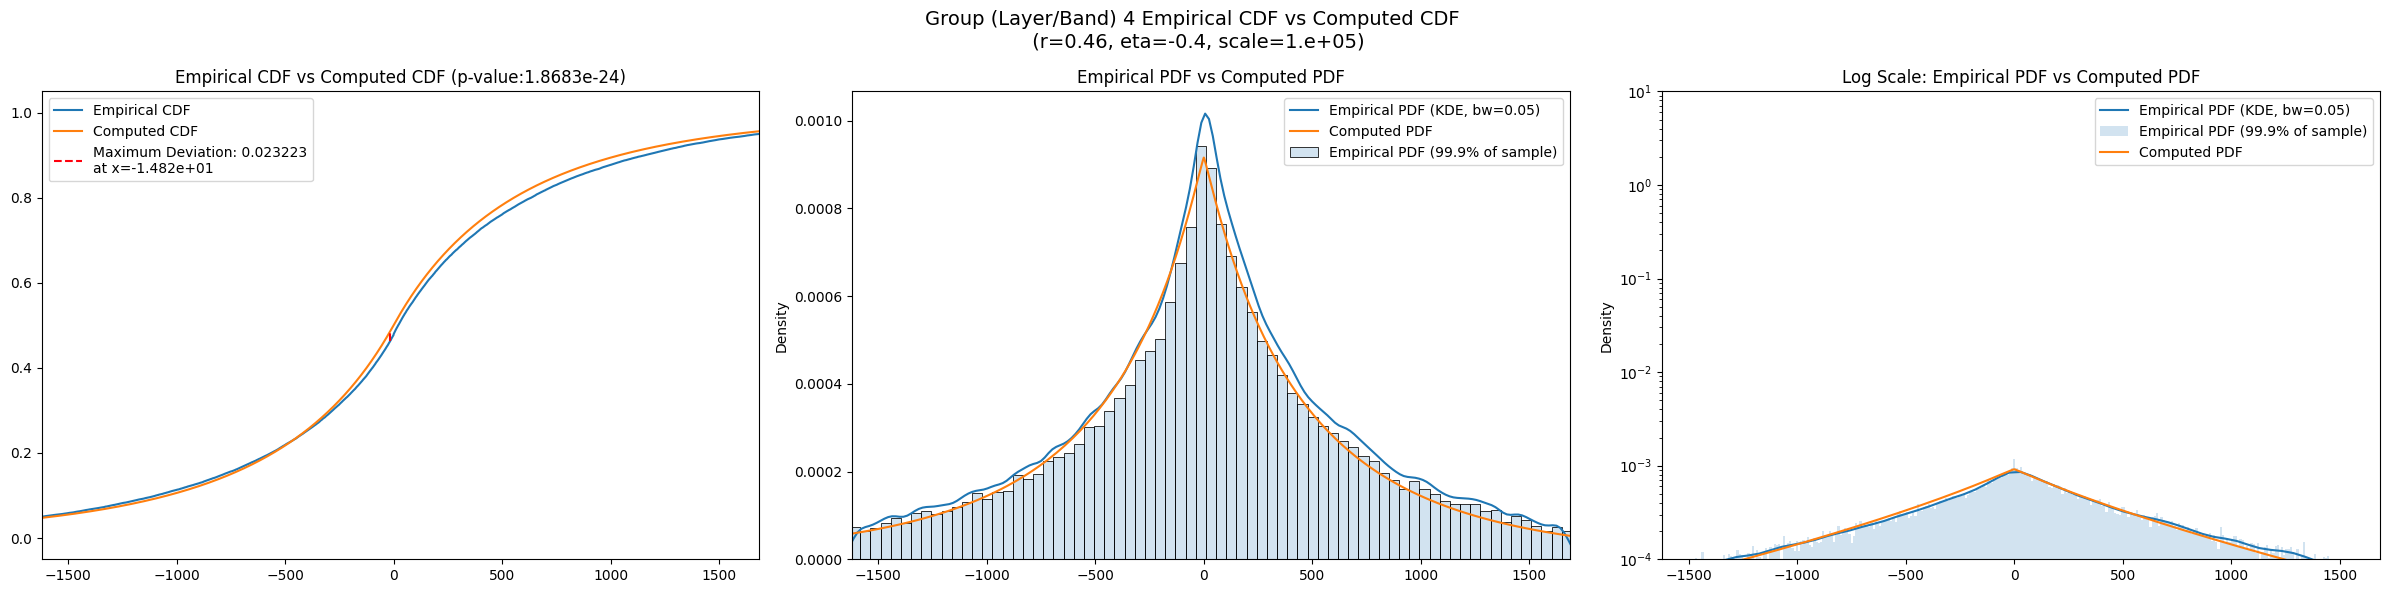

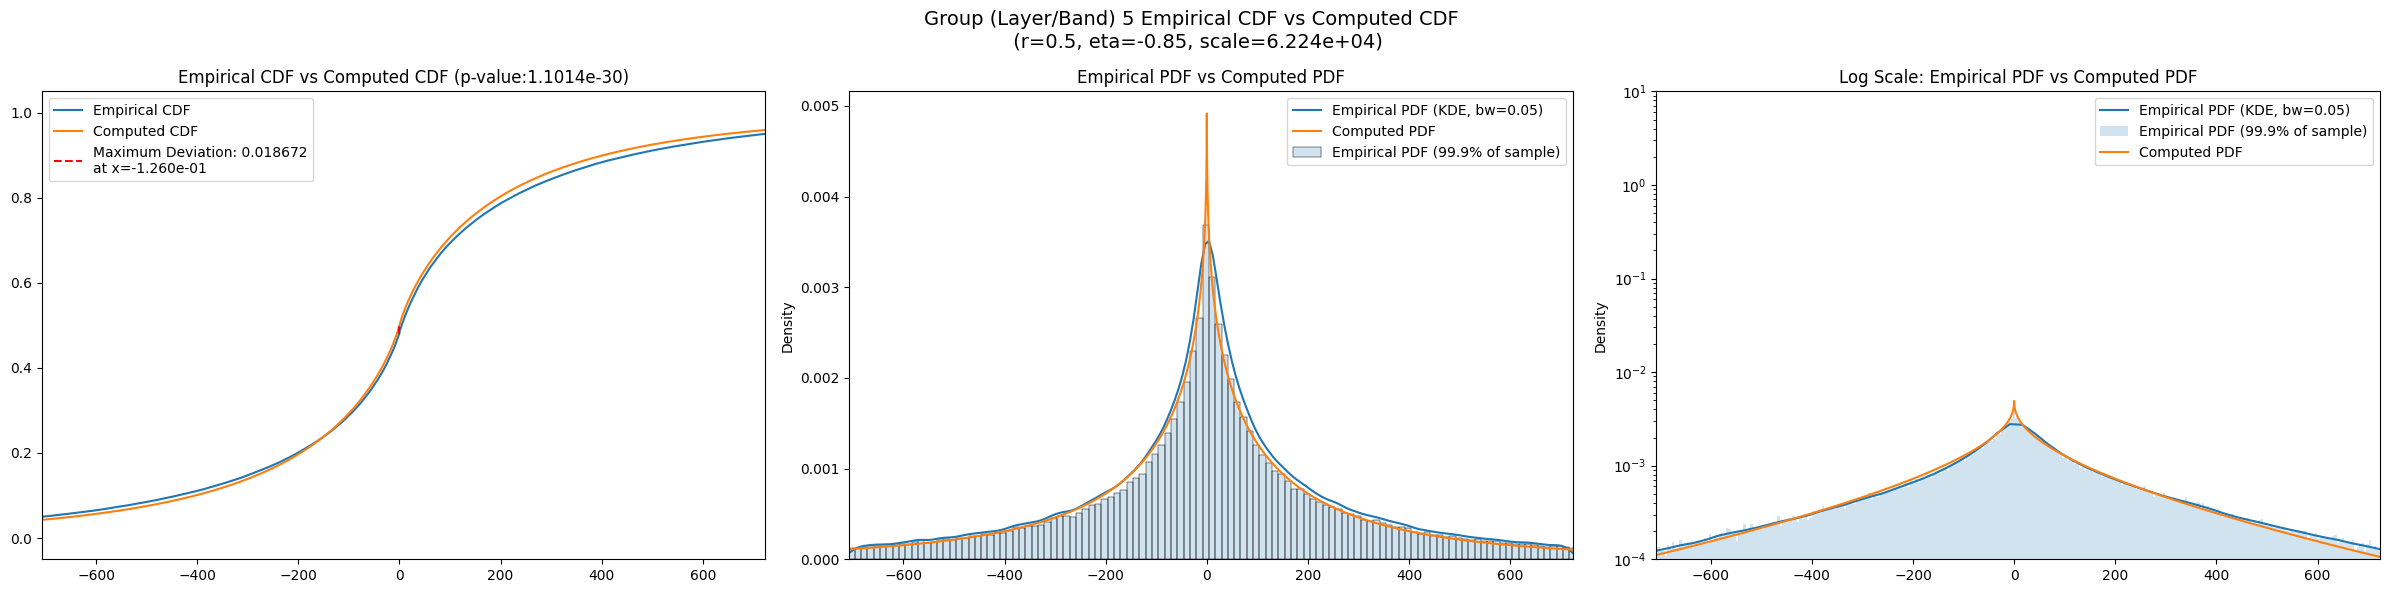

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/plotting.py:454: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


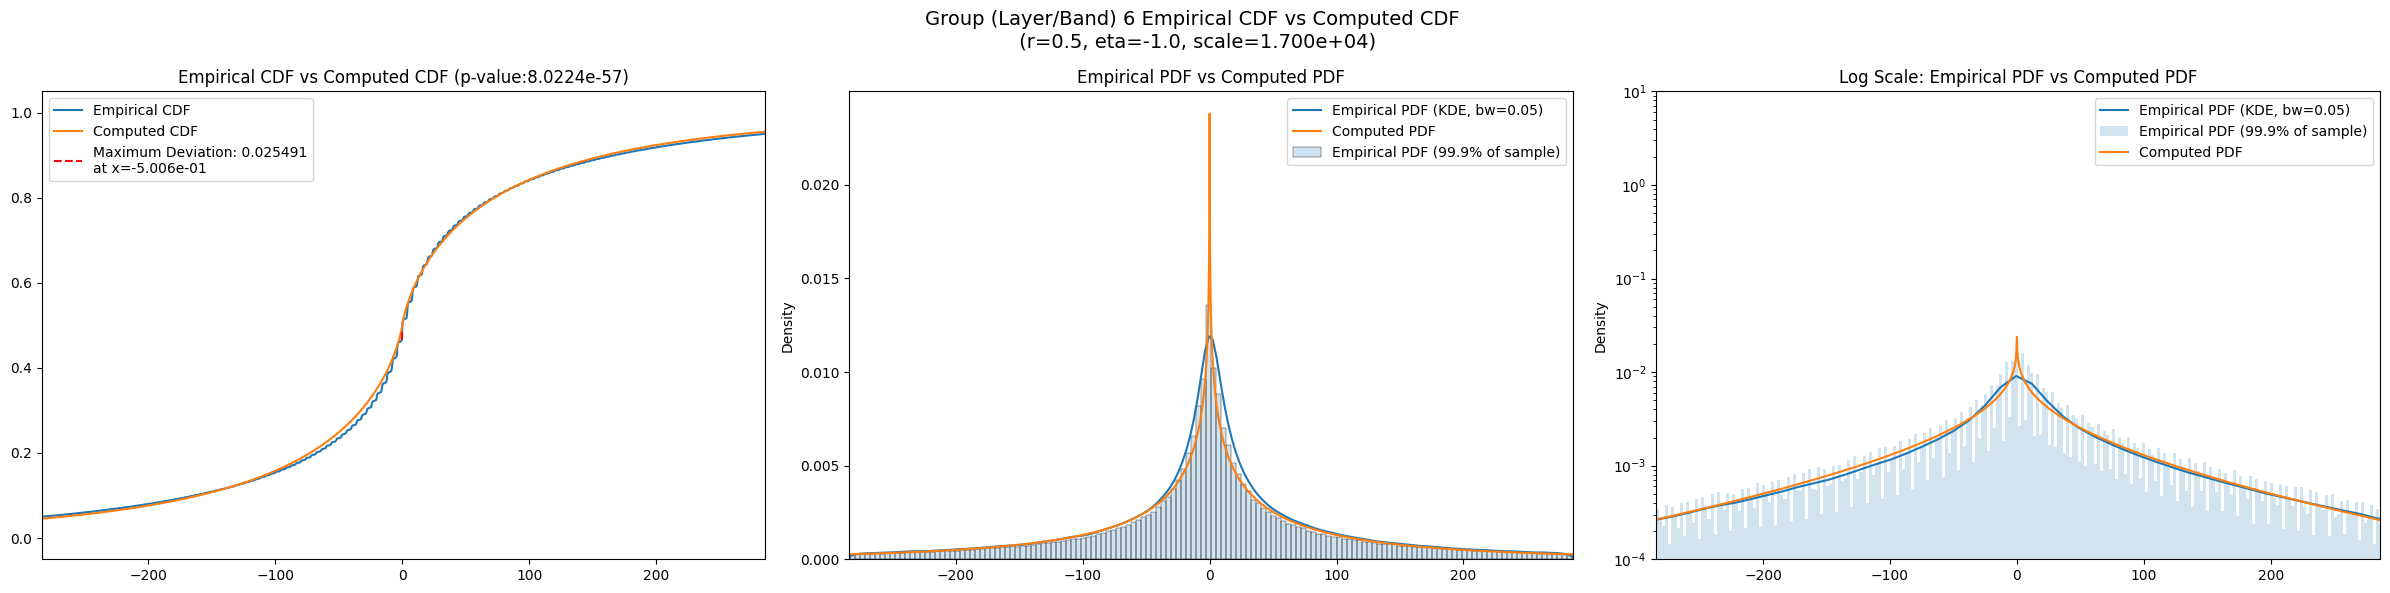

/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_69850/82260372.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)


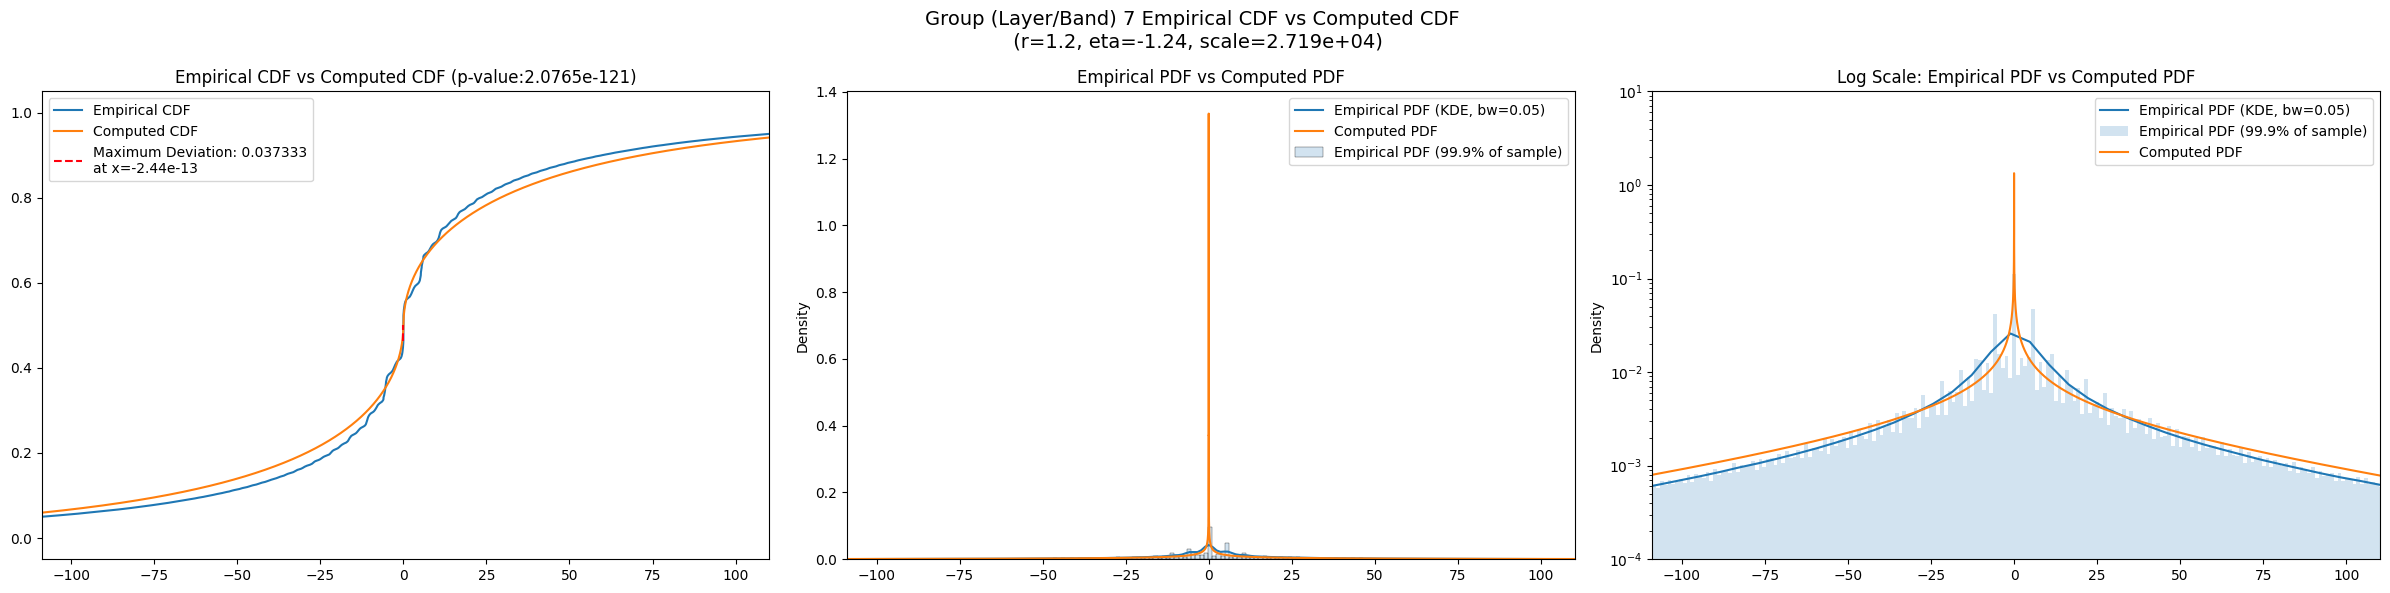

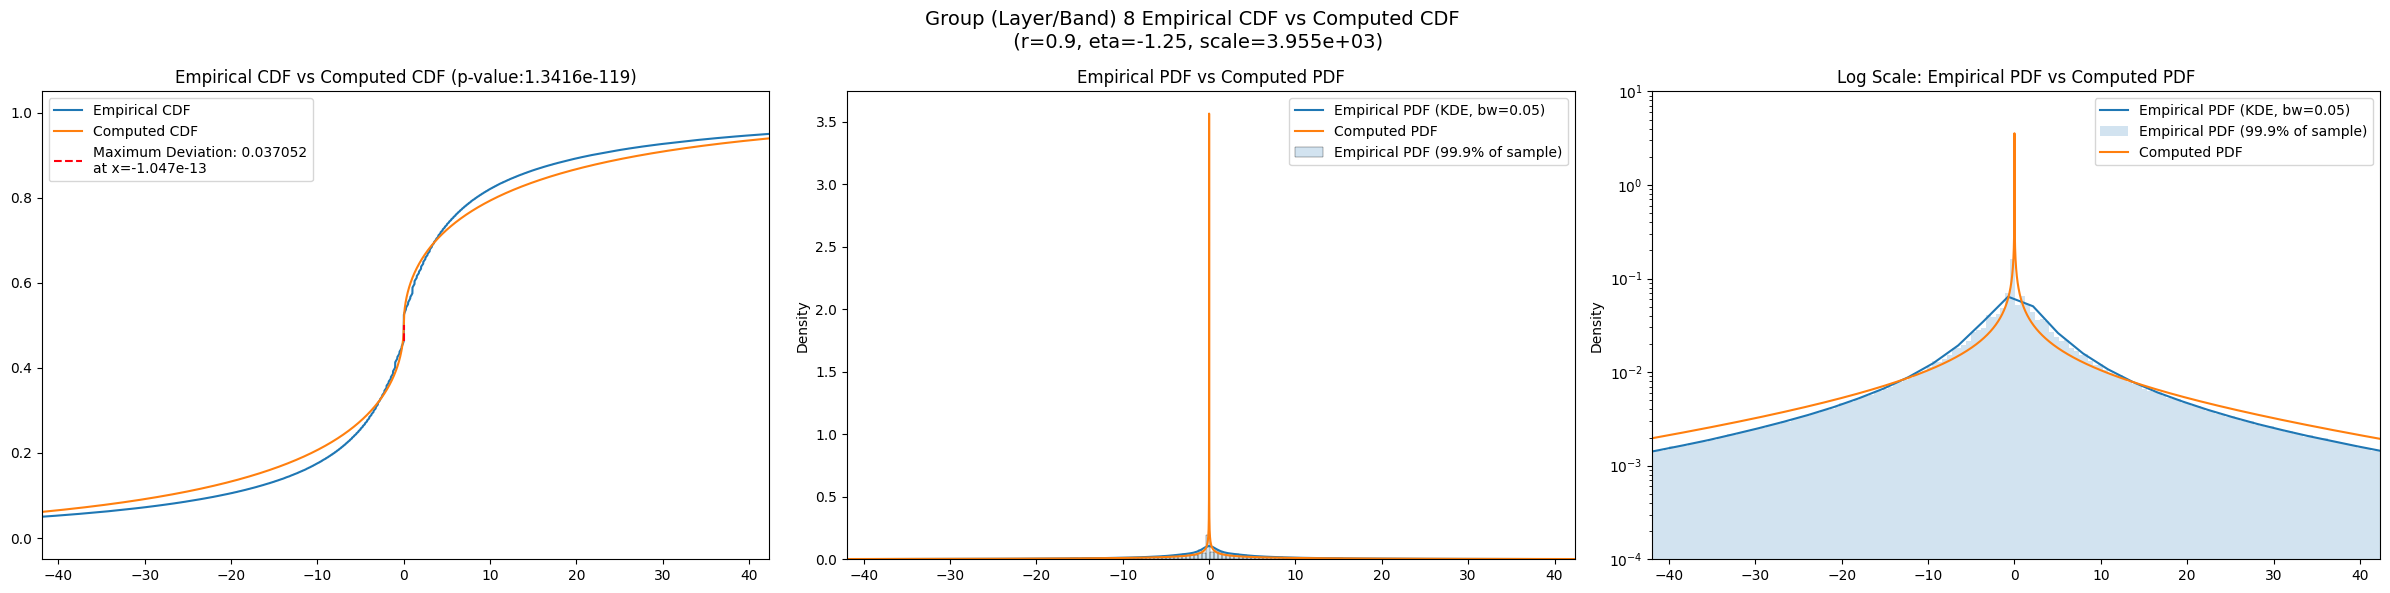

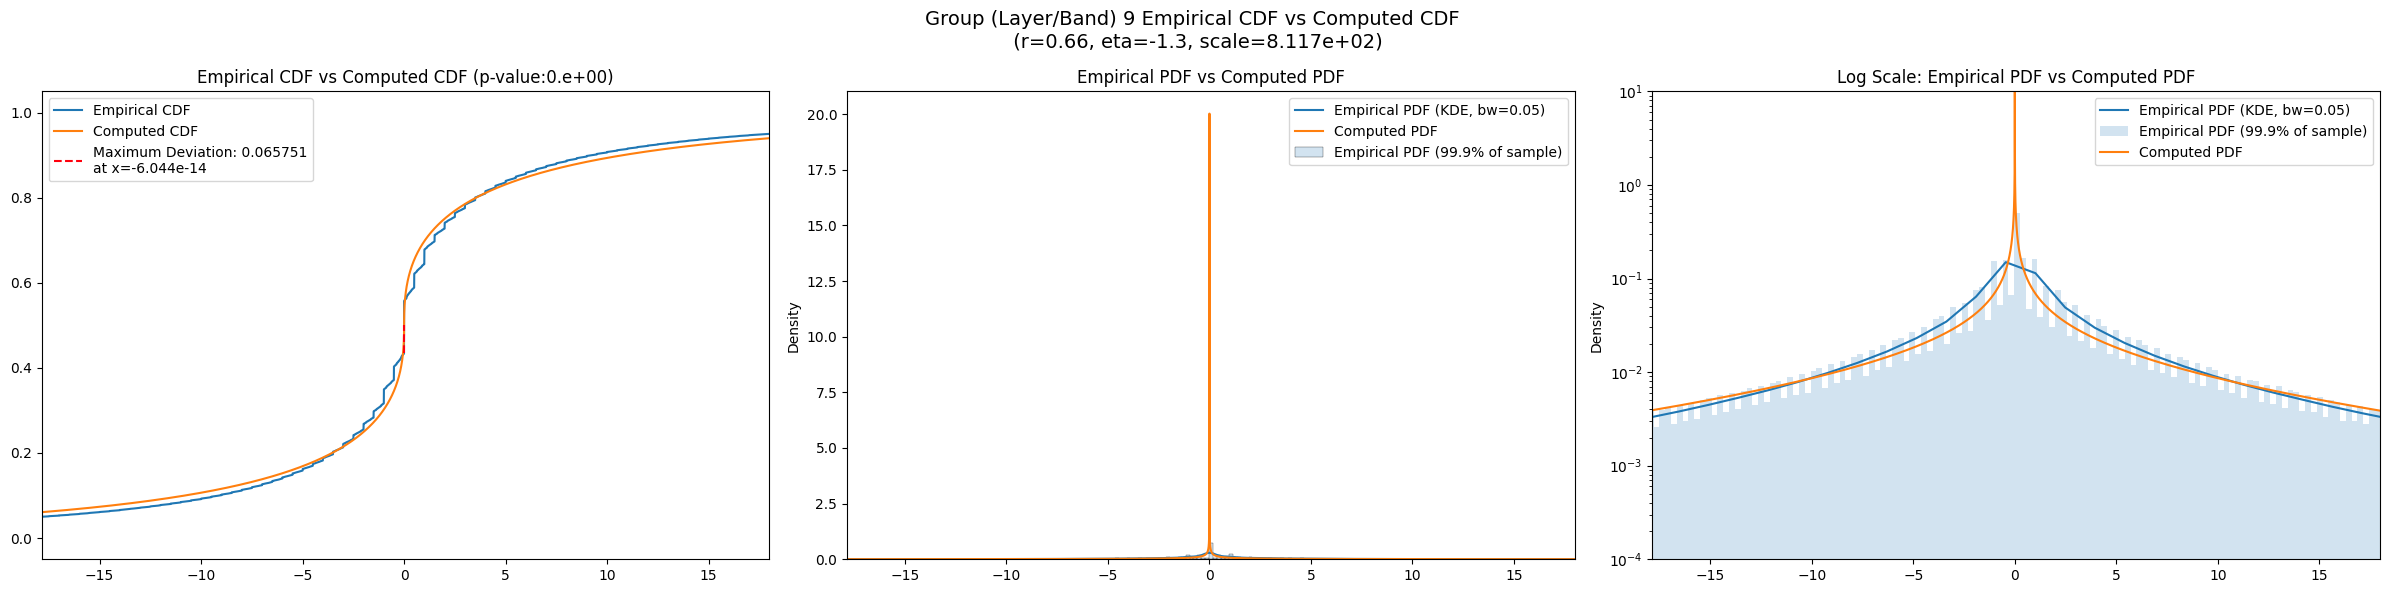

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.167439e+07  2.007571e+07  2.336055e+07   0.787101    0.382352   
3      4.835927e+06  4.598368e+06  5.083178e+06   1.799972    1.476695   
4      1.034581e+06  9.740716e+05  1.099110e+06   3.519323    2.922325   
5      1.983194e+05  1.846769e+05  2.125875e+05   5.446397    4.604024   
6      3.580229e+04  3.279927e+04  3.896280e+04   9.192647    7.647657   
7      6.274311e+03  5.654861e+03  6.950309e+03  14.085468   11.431098   
8      1.189420e+03  1.047309e+03  1.345900e+03  21.680420   17.037355   
9      2.567601e+02  2.218154e+02  2.951868e+02  28.972792   22.108063   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        1.240317         3208.0             0.051189        0.3          5.3   
3        2.147720        12832.0             0.031690        0.4          0.8   
4        4.190051        51328.0             0.023988        0.4         -0.2   
5        6.386241       205312.0             0.018800        0.5         -0.8   
6       10.959983       821248.0             0.025460        0.5         -1.0   
7       17.666815      3284992.0             0.037300        0.8         -1.2   
8       27.775066     13139968.0             0.037020        0.5         -1.2   
9       38.456100     52559872.0             0.065690        0.8         -1.3   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      3935.75000              0.051253          9.179300e-08   
3      ...      1694.99000              0.043976          5.307400e-22   
4      ...       708.00300              0.050550         1.991650e-114   
5      ...       255.22400              0.064678          0.000000e+00   
6      ...        83.74540              0.078065          0.000000e+00   
7      ...        27.22990              0.087231          0.000000e+00   
8      ...        10.90380              0.078099          0.000000e+00   
9      ...         4.16593              0.088438          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2         4385.42000             0.053606         1.878690e-08  3424.01000   
3         1699.21000             0.032397         3.896940e-12  1325.06000   
4          610.57800             0.026470         1.122460e-31   504.54600   
5          219.03800             0.038771        1.374230e-268   175.99900   
6           71.64570             0.052641         0.000000e+00    56.41410   
7           23.51740             0.061572         0.000000e+00    18.29420   
8            9.53742             0.052744         0.000000e+00     7.22352   
9            3.49555             0.065748         0.000000e+00     2.73986   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.051180   9.633300e-08          9.574801e-08  
3           0.032965   1.501410e-12          1.257751e-11  
4           0.032759   2.723880e-48          2.108053e-24  
5           0.042866   0.000000e+00          1.265383e-62  
6           0.055238   0.000000e+00          0.000000e+00  
7           0.062481   0.000000e+00          0.000000e+00  
8           0.053308   0.000000e+00          0.000000e+00  
9           0.065823   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.051189                 0.023925          0.051189   
3                 0.031690                 0.011976          0.031685   
4                 0.023988                 0.005991          0.023186   
5                 0.018800                 0.002996          0.018674   
6                 0.025460                 0.001498          0.025460   
7                 0.037300                 0.000749          0.037300   
8                 0.037020                 0.000375          0.037020   
9                 0.065690                 0.000187          0.065690   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.051253             0.053606       0.051180  
3                  0.043976             0.032397       0.032965  
4                  0.050550             0.026470       0.032759  
5                  0.064678             0.038771       0.042866  
6                  0.078065             0.052641       0.055238  
7                  0.087231             0.061572       0.062481  
8                  0.078099             0.052744       0.053308  
9                  0.088438             0.065748       0.065823

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta     best_scale  \
layer                                                                          
2            2.167439e+07          0.051189    0.30      5.30     557.706657   
3            4.835927e+06          0.031685    0.38      0.90   27850.944431   
4            1.034581e+06          0.023186    0.46     -0.40  100000.000000   
5            1.860904e+05          0.018674    0.50     -0.85   62237.583612   
6            3.400757e+04          0.025460    0.50     -1.00   17003.787109   
7            6.274312e+03          0.037300    1.20     -1.24   27185.819943   
8            1.082473e+03          0.037020    0.90     -1.25    3954.746444   
9            2.567601e+02          0.065690    0.66     -1.30     811.726249   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                    100.0  
6                     50.0  
7                      0.0  
8                     50.0  
9                      0.0

In [21]:
eng.quit()